In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import stats
from plotly.subplots import make_subplots
from numpy import polyfit, poly1d
from scipy.signal import lfilter, savgol_filter
from sklearn import preprocessing
from scipy.stats import entropy

# %matplotlib inline


C:\A\software\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [27]:
def interpolate_pupil(data, window=90):
    data['LeftPupilD'][data['LeftPupilD']<0] = np.nan
    data['RightPupilD'][data['RightPupilD']<0] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    std_left = np.std(data['LeftPupilD'])
    std_right = np.std(data['RightPupilD'])
    mean_left = np.mean(data['LeftPupilD'])
    mean_right = np.mean(data['RightPupilD'])
    data['LeftPupilD'][np.abs(data['LeftPupilD']-mean_left)>3*std_left] = np.nan
    data['RightPupilD'][np.abs(data['RightPupilD']-mean_right)>3*std_right] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data.dropna(axis=0)
    data_s = SG_fil(data,window+1,2)
    return data_s

def SG_fil(data,window,order=2):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = savgol_filter(df.loc[:,n],window,order)
    return df_new  

def left_adjust(coeff_left,x,power):
    if power == 2:
        y = coeff_left[0] * np.power(x,power) + coeff_left[1] * np.power(x,power-1) + coeff_left[2] * np.power(x,power-2)
    if power == 5:
        y = coeff_left[0] * np.power(x,power) + coeff_left[1] * np.power(x,power-1) + coeff_left[2] * np.power(x,power-2) + coeff_left[3] * np.power(x,power-3) + coeff_left[4] * np.power(x,power-4) + coeff_left[5] * np.power(x,power-5)
    return y
def right_adjust(coeff_right,x,power):
    if power == 2:
        y = coeff_right[0] * np.power(x,power) + coeff_right[1] * np.power(x,power-1) + coeff_right[2] * np.power(x,power-2)
    if power == 5:
        y = coeff_right[0] * np.power(x,power) + coeff_right[1] * np.power(x,power-1) + coeff_right[2] * np.power(x,power-2) + coeff_right[3] * np.power(x,power-3) + coeff_right[4] * np.power(x,power-4) + coeff_right[5] * np.power(x,power-5)
    return y

def get_adjust_pupil(lumin, pupil_left, pupil_right, left_average, right_average, power_coeff=2, multi_lumin = 255):
    # coeff_left = [2.52023698e-03, -1.53182328e-01, 4.86556856e+00]
    # coeff_right = [2.50544091e-03, -1.56393294e-01, 5.05585498e+00]
    coeff_left = [2.52023698e-03, -1.53182328e-01, left_average]
    coeff_right = [2.50544091e-03, -1.56393294e-01, right_average]
    lumin_adj = lumin.values.ravel()*multi_lumin
    left_original_pupil = pupil_left.values.ravel()
    right_original_pupil = pupil_right.values.ravel()
    left_adjust_pupil = left_adjust(coeff_left,lumin_adj,power_coeff).ravel()
    right_adjust_pupil = right_adjust(coeff_right,lumin_adj,power_coeff).ravel()
    left_cogload = left_original_pupil - left_adjust_pupil
    right_cogload = right_original_pupil - right_adjust_pupil
    return left_cogload, right_cogload, left_adjust_pupil, right_adjust_pupil


In [32]:
path1 = 'D:/Tianyu/code/python/nist_phase_1/code/Data_NASA/'
path = path1
data_raw=[]
data_collection = ["LeftPupilD","RightPupilD","Lumin","CollisionTargetName","Cube1Name","Cube1X","Cube1Y","Cube1Z",\
            "Cube4Name","Cube4X","Cube4Y","Cube4Z","Cube5Name","Cube5X","Cube5Y","Cube5Z","Cube6Name","Cube6X","Cube6Y",\
                "Cube6Z","HitCube","CollisionTargetDiff","HitCubeDiff","left_adjust_pupil","right_adjust_pupil","left_cogload","right_cogload"]
for home, dirs, files in os.walk(path):
    if not os.path.exists(home + "_cogload/"):
        os.mkdir(home + "_cogload/")
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t = t[200:-1].reset_index()
        t[["LeftPupilD_smooth","RightPupilD_smooth","Lumin_smooth"]] = interpolate_pupil(t[["LeftPupilD","RightPupilD","Lumin"]])
        t[["CollisionTargetName","HitCube"]] = t[["CollisionTargetName","HitCube"]].fillna('')
        t[["CollisionTargetDiff","HitCubeDiff"]] = t[["CollisionTargetName","HitCube"]].ne(t[["CollisionTargetName","HitCube"]].shift().bfill()).astype(int) # faster
        # t[["CollisionTargetDiff","HitCubeDiff"]] = (t[["CollisionTargetName","HitCube"]]!= t[["CollisionTargetName","HitCube"]].shift()).astype(int) # slower
        (left_cogload, right_cogload,left_adjust_pupil, right_adjust_pupil) = get_adjust_pupil(t.Lumin_smooth, t.LeftPupilD_smooth, t.RightPupilD_smooth, np.average(t.LeftPupilD),\
             np.average(t.RightPupilD), multi_lumin=25)
        t["left_adjust_pupil"] = left_adjust_pupil
        t["right_adjust_pupil"] = right_adjust_pupil
        t["left_cogload"] = left_cogload
        t["right_cogload"] = right_cogload
        left_cogload_to0 = left_cogload - np.min(left_cogload)
        right_cogload_to0 = right_cogload - np.min(right_cogload)
        t["left_cogload_to0"] = left_cogload_to0
        t["right_cogload_to0"] = right_cogload_to0


        t.index = range(len(t))
        # t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        # data_raw.append(t[data_collection])
        # data_raw.append(t)

        t.to_csv(home + "_cogload/" + filename)

# participant_num = int(len(data_raw)/2)


D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

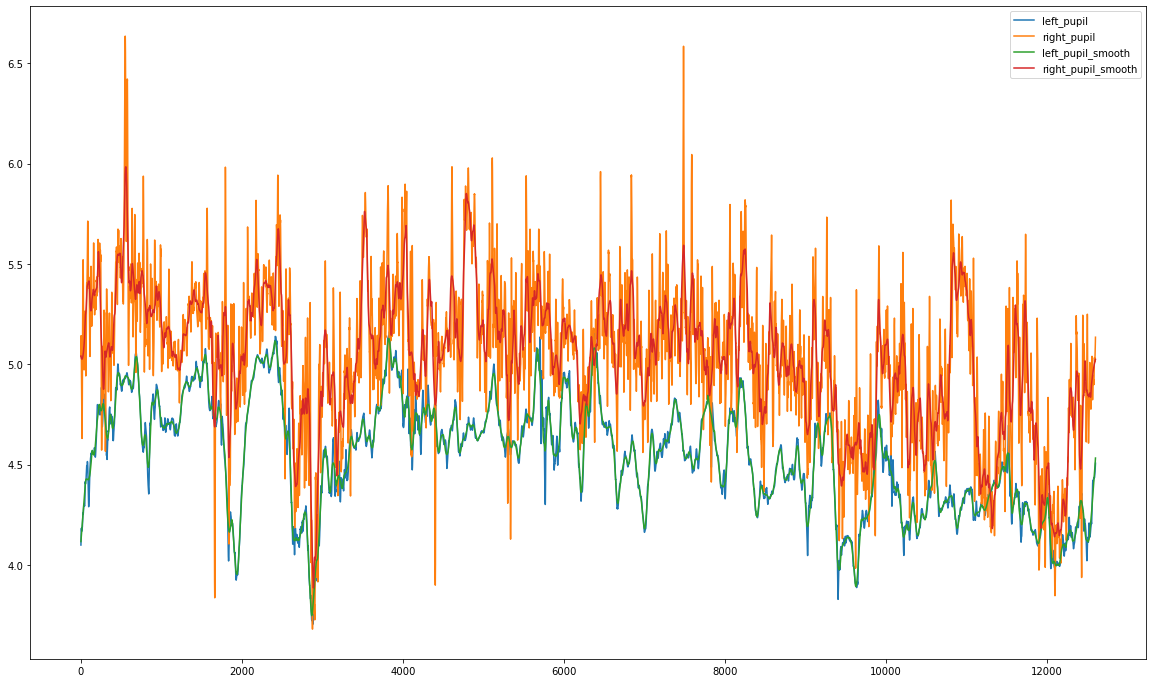

In [30]:
# for test, choose which file
data_index = 1
# start frame
start = 0
# start = 11100
# end frame
end = len(data_raw[data_index][['Lumin']].values)
# end = 11200
# lumin times adjustion
multi_lumin = 1

x_lumin = data_raw[data_index][['Lumin']][start:end].values.ravel()*multi_lumin
left_original_pupil = np.array(data_raw[data_index][['LeftPupilD']][start:end]).ravel()
right_original_pupil = np.array(data_raw[data_index][['RightPupilD']][start:end]).ravel()
right_smooth_pupil = np.array(data_raw[data_index][['RightPupilD_smooth']][start:end]).ravel()
left_smooth_pupil = np.array(data_raw[data_index][['LeftPupilD_smooth']][start:end]).ravel()


left_cogload = np.array(data_raw[data_index][['left_cogload']][start:end]).ravel()
right_cogload = np.array(data_raw[data_index][['right_cogload']][start:end]).ravel()
left_adjust_pupil = np.array(data_raw[data_index][['left_adjust_pupil']][start:end]).ravel()
right_adjust_pupil = np.array(data_raw[data_index][['right_adjust_pupil']][start:end]).ravel()

# rolling_right = np.array(data_raw[data_index][['RightPupilD']][start:end].rolling(10,closed="both").median().fillna(method="bfill").fillna(method="ffill")).ravel()
plt.figure(figsize=(20, 12))
plt.plot(left_original_pupil, label='left_pupil')
plt.plot(right_original_pupil, label='right_pupil')
plt.plot(left_smooth_pupil, label='left_pupil_smooth')
plt.plot(right_smooth_pupil, label='right_pupil_smooth')
# plt.plot(left_adjust_pupil, label='left_lumin_adj')
# plt.plot(right_adjust_pupil, label='right_lumin_adj')
# plt.plot(left_cogload, label='left_cogload')
# plt.plot(right_cogload, label='right_cogload')

# plt.plot(rolling_right, label='rolling_right')
# plt.plot(x_lumin*25, label='lumin')
plt.legend()
plt.show()

In [11]:
data_index = 5
change_list_hit = data_raw[data_index]["HitCubeDiff"][data_raw[data_index]["HitCubeDiff"] == 1]
change_list_cillision = data_raw[data_index]["CollisionTargetDiff"][data_raw[data_index]["CollisionTargetDiff"] == 1]
# data_raw[data_index]["CollisionTargetDiff"][data_raw[data_index]["CollisionTargetDiff"] == 1]

In [30]:
data_raw[data_index][["CollisionTargetName","HitCube"]].iloc[change_list_cillision.index[0]]


CollisionTargetName    Object_Start
HitCube                            
Name: 1674, dtype: object

In [33]:
cube_list = ["Object_White", "Object_Purple", "Object4_Green", "Object4_Blue"]
target_list = ["Object_White_ID1", "Object_Purple_ID2", "Object4_Green_ID3", "Object4_Blue_ID4"]
### sample from raw data 
rate = 1
data_image = copy.deepcopy(data_raw[data_index])
subset = data_image[::rate]

## 3D Stastic ###
df = subset[subset["CollisionTargetName"]=="Object_White"]

fig = px.scatter_3d(df, x='RobotX', y='RobotY', z='RobotZ',
            color='left_cogload',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8,) #symbol='CollisionTargetName',symbol_sequence=["cross","circle"]
fig.update_traces(marker_size = 3)

fig.show()

In [21]:
# dir(px.colors.qualitative)
dir(px.colors.sequential)

['Aggrnyl',
 'Aggrnyl_r',
 'Agsunset',
 'Agsunset_r',
 'Blackbody',
 'Blackbody_r',
 'Bluered',
 'Bluered_r',
 'Blues',
 'Blues_r',
 'Blugrn',
 'Blugrn_r',
 'Bluyl',
 'Bluyl_r',
 'Brwnyl',
 'Brwnyl_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'Burg',
 'Burg_r',
 'Burgyl',
 'Burgyl_r',
 'Cividis',
 'Cividis_r',
 'Darkmint',
 'Darkmint_r',
 'Electric',
 'Electric_r',
 'Emrld',
 'Emrld_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Hot',
 'Hot_r',
 'Inferno',
 'Inferno_r',
 'Jet',
 'Jet_r',
 'Magenta',
 'Magenta_r',
 'Magma',
 'Magma_r',
 'Mint',
 'Mint_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'Oryel',
 'Oryel_r',
 'Peach',
 'Peach_r',
 'Pinkyl',
 'Pinkyl_r',
 'Plasma',
 'Plasma_r',
 'Plotly3',
 'Plotly3_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuRd',
 'PuRd_r',
 'Purp',
 'Purp_r',
 'Purples',
 'Purples_r',
 'Purpor',
 'Purpor_r',
 'Rainbow',
 'Rainbow_r',
 'RdBu',
 'RdBu_r',
 'RdPu',
 'RdPu_r',
 'Redor',
 'Redor_r',
 'Reds',
 'Reds_r',
 'Sunset

In [ ]:
path1 = 'D:/Tianyu/code/python/nasa/nasa_data/v_2/'
path = path1
data_raw=[]
data_collection = ["LeftPupilD","RightPupilD","Lumin","CollisionTargetName","Cube1Name","Cube1X","Cube1Y","Cube1Z",\
            "Cube4Name","Cube4X","Cube4Y","Cube4Z","Cube5Name","Cube5X","Cube5Y","Cube5Z","Cube6Name","Cube6X","Cube6Y",\
                "Cube6Z","HitCube","CollisionTargetDiff","HitCubeDiff","left_adjust_pupil","right_adjust_pupil","left_cogload","right_cogload"]
for home, dirs, files in os.walk(path):
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t[["LeftPupilD_smooth","RightPupilD_smooth","Lumin_smooth"]] = interpolate_pupil(t[["LeftPupilD","RightPupilD","Lumin"]])
        t[["CollisionTargetName","HitCube"]] = t[["CollisionTargetName","HitCube"]].fillna('')
        t[["CollisionTargetDiff","HitCubeDiff"]] = t[["CollisionTargetName","HitCube"]].ne(t[["CollisionTargetName","HitCube"]].shift().bfill()).astype(int) # faster
        # t[["CollisionTargetDiff","HitCubeDiff"]] = (t[["CollisionTargetName","HitCube"]]!= t[["CollisionTargetName","HitCube"]].shift()).astype(int) # slower
        (left_cogload, right_cogload,left_adjust_pupil, right_adjust_pupil) = get_adjust_pupil(t.Lumin_smooth, t.LeftPupilD_smooth, t.RightPupilD_smooth, np.average(t.LeftPupilD),\
             np.average(t.RightPupilD), multi_lumin=25)
        t["left_adjust_pupil"] = left_adjust_pupil
        t["right_adjust_pupil"] = right_adjust_pupil
        t["left_cogload"] = left_cogload
        t["right_cogload"] = right_cogload
        left_cogload_to0 = left_cogload - np.min(left_cogload)
        right_cogload_to0 = right_cogload - np.min(right_cogload)
        t["left_cogload_to0"] = left_cogload_to0
        t["right_cogload_to0"] = right_cogload_to0


        t.index = range(len(t))
        # t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        # data_raw.append(t[data_collection])
        # data_raw.append(t)

        t.to_csv(home + "_cogload/" + filename)

# participant_num = int(len(data_raw)/2)

In [20]:
path = 'D:/Tianyu/code/python/nasa/nasa_data/v_2/'
data_raw=[]
for home, dirs, files in os.walk(path):
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)


In [ ]:
vel_cube1_x = []
v_previous = 0
name = 'Cube1X'
for i,v in t[name].iteritems():
    if abs(v-v_previous)>0.5:
        vel_cube1_x.append(0)
    # elif abs(v-v_previous)>0:
    else:
        vel_cube1_x.append(v-v_previous)
    v_previous = v
vel_df = pd.DataFrame({"vel_x":vel_cube1_x[14500:20000]})

In [230]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))
    
m = 2

In [12]:
def get_entropy(t,name,column_name):
    vel_x = []
    vel_y = []
    vel_z = []
    p_x_previous = 0
    p_y_previous = 0
    p_z_previous = 0

    for i,p_x in t[column_name + 'X'].iteritems():
        delta_p_x = p_x-p_x_previous
        if abs(delta_p_x)>0.5:
            vel_x.append(0)
        # elif abs(delta_v_x)>0:
        else:
            vel_x.append(delta_p_x)
        p_x_previous = p_x
    t["vel_x"] = vel_x
    for i,p_y in t[column_name + 'Y'].iteritems():
        delta_p_y = p_y-p_y_previous
        if abs(delta_p_y)>0.5:
            vel_y.append(0)
        # elif abs(delta_v_y)>0:
        else:
            vel_y.append(delta_p_y)
        p_y_previous = p_y
    t["vel_y"] = vel_y
    for i,p_z in t[column_name + 'Z'].iteritems():
        delta_p_z = p_z-p_z_previous
        if abs(delta_p_z)>0.5:
            vel_z.append(0)
        # elif abs(delta_v_z)>0:
        else:
            vel_z.append(delta_p_z)
        p_z_previous = p_z
    t["vel_z"] = vel_z
    
    
    control_group = t.dropna(axis=1)
    control_group['Conditions'][control_group['Conditions'] != "control"] = np.nan
    control_group = control_group.dropna(axis=0)
    control_group.index = range(len(control_group))
    control_pd_groupby = control_group.groupby(['ID'])

    Anchoring_group = t.dropna(axis=1)
    Anchoring_group['Conditions'][Anchoring_group['Conditions'] != "Anchoring"] = np.nan
    Anchoring_group = Anchoring_group.dropna(axis=0)
    Anchoring_group.index = range(len(Anchoring_group))
    Anchoring_pd_groupby = Anchoring_group.groupby(['ID'])

    Asynchronized_group = t.dropna(axis=1)
    Asynchronized_group['Conditions'][Asynchronized_group['Conditions'] != "Asynchronized"] = np.nan
    Asynchronized_group = Asynchronized_group.dropna(axis=0)
    Asynchronized_group.index = range(len(Asynchronized_group))
    Asynchronized_pd_groupby = Asynchronized_group.groupby(['ID'])

    Synchronized_group = t.dropna(axis=1)
    Synchronized_group['Conditions'][Synchronized_group['Conditions'] != "Synchronized"] = np.nan
    Synchronized_group = Synchronized_group.dropna(axis=0)
    Synchronized_group.index = range(len(Synchronized_group))
    Synchronized_pd_groupby = Synchronized_group.groupby(['ID'])
    
    
    control_pos_x_entropy = []
    control_pos_y_entropy = []
    control_pos_z_entropy = []
    control_vel_x_entropy = []
    control_vel_y_entropy = []
    control_vel_z_entropy = []
    control_vel_x_mean = []
    control_vel_y_mean = []
    control_vel_z_mean = []
    for h,d in control_pd_groupby:
        control_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        control_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        control_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        control_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        control_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        control_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        control_vel_x_mean.append(d['vel_x'].values.mean())
        control_vel_y_mean.append(d['vel_y'].values.mean())
        control_vel_z_mean.append(d['vel_z'].values.mean())

    Anchoring_pos_x_entropy = []
    Anchoring_pos_y_entropy = []
    Anchoring_pos_z_entropy = []
    Anchoring_vel_x_entropy = []
    Anchoring_vel_y_entropy = []
    Anchoring_vel_z_entropy = []
    Anchoring_vel_x_mean = []
    Anchoring_vel_y_mean = []
    Anchoring_vel_z_mean = []
    for h,d in Anchoring_pd_groupby:
        Anchoring_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Anchoring_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Anchoring_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Anchoring_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Anchoring_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Anchoring_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Anchoring_vel_x_mean.append(d['vel_x'].values.mean())
        Anchoring_vel_y_mean.append(d['vel_y'].values.mean())
        Anchoring_vel_z_mean.append(d['vel_z'].values.mean())


    Asynchronized_pos_x_entropy = []
    Asynchronized_pos_y_entropy = []
    Asynchronized_pos_z_entropy = []
    Asynchronized_vel_x_entropy = []
    Asynchronized_vel_y_entropy = []
    Asynchronized_vel_z_entropy = []
    Asynchronized_vel_x_mean = []
    Asynchronized_vel_y_mean = []
    Asynchronized_vel_z_mean = []
    for h,d in Asynchronized_pd_groupby:
        Asynchronized_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Asynchronized_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Asynchronized_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Asynchronized_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Asynchronized_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Asynchronized_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Asynchronized_vel_x_mean.append(d['vel_x'].values.mean())
        Asynchronized_vel_y_mean.append(d['vel_y'].values.mean())
        Asynchronized_vel_z_mean.append(d['vel_z'].values.mean())


    Synchronized_pos_x_entropy = []
    Synchronized_pos_y_entropy = []
    Synchronized_pos_z_entropy = []
    Synchronized_vel_x_entropy = []
    Synchronized_vel_y_entropy = []
    Synchronized_vel_z_entropy = []
    Synchronized_vel_x_mean = []
    Synchronized_vel_y_mean = []
    Synchronized_vel_z_mean = []
    for h,d in Synchronized_pd_groupby:
        Synchronized_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Synchronized_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Synchronized_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Synchronized_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Synchronized_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Synchronized_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Synchronized_vel_x_mean.append(d['vel_x'].values.mean())
        Synchronized_vel_y_mean.append(d['vel_y'].values.mean())
        Synchronized_vel_z_mean.append(d['vel_z'].values.mean())

    a = {
    'control_pos_x_entropy':control_pos_x_entropy,'control_pos_y_entropy':control_pos_y_entropy,'control_pos_z_entropy':control_pos_z_entropy,
    'control_vel_x_entropy':control_vel_x_entropy,'control_vel_y_entropy':control_vel_y_entropy,'control_vel_z_entropy':control_vel_z_entropy,
    'control_vel_x_mean':control_vel_x_mean,'control_vel_y_mean':control_vel_y_mean,'control_vel_z_mean':control_vel_z_mean,

    'Anchoring_pos_x_entropy':Anchoring_pos_x_entropy,'Anchoring_pos_y_entropy':Anchoring_pos_y_entropy,'Anchoring_pos_z_entropy':Anchoring_pos_z_entropy,
    'Anchoring_vel_x_entropy':Anchoring_vel_x_entropy,'Anchoring_vel_y_entropy':Anchoring_vel_y_entropy,'Anchoring_vel_z_entropy':Anchoring_vel_z_entropy,
    'Anchoring_vel_x_mean':Anchoring_vel_x_mean,'Anchoring_vel_y_mean':Anchoring_vel_y_mean,'Anchoring_vel_z_mean':Anchoring_vel_z_mean,

    'Asynchronized_pos_x_entropy':Asynchronized_pos_x_entropy,'Asynchronized_pos_y_entropy':Asynchronized_pos_y_entropy,'Asynchronized_pos_z_entropy':Asynchronized_pos_z_entropy,
    'Asynchronized_vel_x_entropy':Asynchronized_vel_x_entropy,'Asynchronized_vel_y_entropy':Asynchronized_vel_y_entropy,'Asynchronized_vel_z_entropy':Asynchronized_vel_z_entropy,
    'Asynchronized_vel_x_mean':Asynchronized_vel_x_mean,'Asynchronized_vel_y_mean':Asynchronized_vel_y_mean,'Asynchronized_vel_z_mean':Asynchronized_vel_z_mean,

    'Synchronized_pos_x_entropy':Synchronized_pos_x_entropy,'Synchronized_pos_y_entropy':Synchronized_pos_y_entropy,'Synchronized_pos_z_entropy':Synchronized_pos_z_entropy,
    'Synchronized_vel_x_entropy':Synchronized_vel_x_entropy,'Synchronized_vel_y_entropy':Synchronized_vel_y_entropy,'Synchronized_vel_z_entropy':Synchronized_vel_z_entropy,
    'Synchronized_vel_x_mean':Synchronized_vel_x_mean,'Synchronized_vel_y_mean':Synchronized_vel_y_mean,'Synchronized_vel_z_mean':Synchronized_vel_z_mean,
    }
    entropy_df = pd.DataFrame.from_dict(a,orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(home+"/"+ name + "_entropy.csv")

    control_df = pd.DataFrame([
        control_pos_x_entropy,control_pos_y_entropy,control_pos_z_entropy,
        control_vel_x_entropy,control_vel_y_entropy,control_vel_z_entropy,
        control_vel_x_mean,control_vel_y_mean,control_vel_z_mean
        ]).transpose()
    control_df["Groups"] = "Control"

    Anchoring_df = pd.DataFrame([
        Anchoring_pos_x_entropy,Anchoring_pos_y_entropy,Anchoring_pos_z_entropy,
        Anchoring_vel_x_entropy,Anchoring_vel_y_entropy,Anchoring_vel_z_entropy,
        Anchoring_vel_x_mean,Anchoring_vel_y_mean,Anchoring_vel_z_mean
        ]).transpose()
    Anchoring_df["Groups"] = "Anchoring"

    Asynchronized_df = pd.DataFrame([
        Asynchronized_pos_x_entropy,Asynchronized_pos_y_entropy,Asynchronized_pos_z_entropy,
        Asynchronized_vel_x_entropy,Asynchronized_vel_y_entropy,Asynchronized_vel_z_entropy,
        Asynchronized_vel_x_mean,Asynchronized_vel_y_mean,Asynchronized_vel_z_mean
        ]).transpose()
    Asynchronized_df["Groups"] = "Asynchronized"

    Synchronized_df = pd.DataFrame([
        Synchronized_pos_x_entropy,Synchronized_pos_y_entropy,Synchronized_pos_z_entropy,
        Synchronized_vel_x_entropy,Synchronized_vel_y_entropy,Synchronized_vel_z_entropy,
        Synchronized_vel_x_mean,Synchronized_vel_y_mean,Synchronized_vel_z_mean
        ]).transpose()
    Synchronized_df["Groups"] = "Synchronized"

    total_df = pd.concat([control_df,Anchoring_df,Asynchronized_df,Synchronized_df])
    total_df.columns = ["entropy_pos_x","entropy_pos_y","entropy_pos_z","entropy_vel_x","entropy_vel_y","entropy_vel_z","mean_vel_x","mean_vel_y","mean_vel_z","Groups"]
    total_df.to_csv((home+"/"+ name + "_combine.csv"))


In [84]:
### calculate the hit times
def calculate_pick_time(h,d,column_name,cube_name,target_name,interval=-90):
    if len(d)>interval:
        for i in range(d.index[-1],d.index[0],interval):
            # d.iloc[i+interval:i]["CollisionTargetName"].value_counts()[cube_name]
            grouped_df = d.iloc[i+interval:i].groupby(['CollisionTargetName'])
            labels = grouped_df.size().index
            if cube_name not in labels:
                d = d.drop(d.index[i+interval:i])
            elif (grouped_df.size()[cube_name]<30):
                d = d.drop(d.index[i+interval:i])
        return d

In [90]:
### find the time interval ###
def get_time_interval(h,d,column_name,interval=45):
    time_interval = []
    previous_state = True
    current_state = True
    if len(d)<91:
        time_interval.append([0,'length too short',h])
    else:
        for i in range(d.index[0],d.index[-1],interval):
            current_state = (d[[column_name + 'X',column_name + 'Y',column_name + 'Z']].iloc[i:i+interval].ne(d[[column_name + 'X',column_name + 'Y',column_name + 'Z']].iloc[i:i+interval].shift().bfill()).astype(int).mean().values == [0,0,0]).all()
            if (previous_state and not current_state):
                start_point = i
            if (current_state and not previous_state):
                end_point = i
                time_interval.append([start_point,end_point,h])
            if (i>d.index[-1]-interval-1):
                end_point = d.index[-1]
                time_interval.append([start_point,end_point,h])
            previous_state = current_state
    return time_interval

In [93]:
path = 'D:/code/python/nasa/data/test/'

column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
cube_list = ["Object_White", "Object_Purple", "Object4_Green", "Object4_Blue"]
target_list = ["Object_White_ID1", "Object_Purple_ID2", "Object4_Green_ID3", "Object4_Blue_ID4"]

local_name = locals()
total_time_interval = []

n=0
for home, dirs, files in os.walk(path):
    for filename in files:
        name = filename[0]
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t['Conditions'] = t['Conditions'].str.strip()
        t['ID'] = t['ID'].str.strip()
        column_name = local_name['column_' + name]
        print(name)
        local_name[name+'_part_clean'] = pd.DataFrame()

        if name == 'W':
            cube_name = cube_list[0]
            target_name = target_list[0]
        elif name == 'P':
            cube_name = cube_list[1]
            target_name = target_list[1]
        elif name == 'G':
            cube_name = cube_list[2]
            target_name = target_list[2]
        elif name == 'B':
            cube_name = cube_list[3]
            target_name = target_list[3]
        
        
        for axis in axis3:
            local_name['vel_' + axis] = []
            local_name['acc_' + axis] = []
            local_name['p_' + axis + '_previous'] = 0
            local_name['vel_' + axis + '_previous'] = 0

            for i,local_name['p_' + axis] in t[column_name + axis].iteritems():
                ## get vel by delta_p
                local_name['delta_p_' + axis] = local_name['p_' + axis] - local_name['p_' + axis + '_previous']
                if abs(local_name['delta_p_' + axis])>5.0:
                    local_name['vel_' + axis].append(0)
                else:
                    local_name['vel_' + axis].append(local_name['delta_p_' + axis])
                local_name['p_' + axis + '_previous'] = local_name['p_' + axis]

                ## get acc by delta_vel
                local_name['delta_vel_' + axis] = local_name['delta_p_' + axis] - local_name['vel_' + axis + '_previous']
                local_name['acc_' + axis].append(local_name['delta_vel_' + axis])
                local_name['vel_' + axis + '_previous'] = local_name['delta_p_' + axis]

            t["vel_" + axis] = local_name['vel_' + axis]
            t["acc_" + axis] = local_name['acc_' + axis]


        for group in groups:
            # local_name[group + '_group'] = t.dropna(axis=1)
            local_name[group + '_group'] = t.copy()
            local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
            local_name[group + '_group'] = local_name[group + '_group'].dropna(axis=0,subset=['Conditions'])
            local_name[group + '_group'].index = range(len(local_name[group + '_group']))
            local_name[group+'_pd_groupby'] = local_name[group + '_group'].groupby(['ID'])

            local_name[group+'_outlier_header'] = []
            local_name[group+'_clean_df'] = pd.DataFrame()
            for h,d in local_name[group+'_pd_groupby']:
                d.index = range(len(d))
                _df = (calculate_pick_time(h,d,column_name,cube_name,target_name))
                local_name[group+'_clean_df'] = pd.concat([local_name[group+'_clean_df'],_df],ignore_index=True)
            local_name[group+'_clean_df'].to_csv(path + name + "_" + group + "_part_clean.csv")
            local_name[name+'_part_clean'] = pd.concat([local_name[name+'_part_clean'],local_name[group+'_clean_df']],ignore_index=True)
        local_name[name+'_part_clean'].to_csv(path + name + '_part_clean.csv')


B


<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

G


<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

P


<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

W


<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
<ipython-input-93-2d2d55fcbf88>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [ ]:
### not use ###
for group in groups:
    local_name[group+'_time_interval_groupby'] = local_name[name+'_part_clean'].groupby(['ID'])
    for h,d in local_name[group+'_pd_groupby']:
        time_interval = get_time_interval(h,d,column_name)
        if time_interval != []:
            total_time_interval.append(time_interval)
# np.save(home+"/"+name + "_time_interval.npy",total_time_interval)
# np.savetxt(home+"/"+name + "_time_interval.npy", total_time_interval, delimiter=",")
df_save = pd.DataFrame()


In [227]:
### clean data (moving average clean) ###
def moving_average_clean(h,d,interval=-45):
    for i in range(d.index[-1],d.index[0],interval):
        if (d[[column_name + 'X',column_name + 'Y',column_name + 'Z']].iloc[i+interval:i].ne(d[[column_name + 'X',column_name + 'Y',column_name + 'Z']].iloc[i+interval:i].shift().bfill()).astype(int).mean().values == [0,0,0]).all():
            d = d.drop(d.index[i+interval:i])
    if len(d)>90:
        h=None
    else:
        d=pd.DataFrame()
    return h,d

In [228]:
path = 'D:/code/python/nasa/data/test/'

column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']

local_name = locals()

n=0
for home, dirs, files in os.walk(path):
    for filename in files:
        name = filename[0]
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t['Conditions'] = t['Conditions'].str.strip()
        t['ID'] = t['ID'].str.strip()

        # column_name = local_name['column_' + name]
        column_name = 'Robot'
        print(name)
        local_name[name+'_part_clean'] = pd.DataFrame()        
        
        for axis in axis3:
            local_name['vel_' + axis] = []
            local_name['acc_' + axis] = []
            local_name['p_' + axis + '_previous'] = 0
            local_name['vel_' + axis + '_previous'] = 0

            for i,local_name['p_' + axis] in t[column_name + axis].iteritems():
                ## get vel by delta_p
                local_name['delta_p_' + axis] = local_name['p_' + axis] - local_name['p_' + axis + '_previous']
                if abs(local_name['delta_p_' + axis])>5.0:
                    local_name['vel_' + axis].append(0)
                else:
                    local_name['vel_' + axis].append(local_name['delta_p_' + axis])
                local_name['p_' + axis + '_previous'] = local_name['p_' + axis]

                ## get acc by delta_vel
                local_name['delta_vel_' + axis] = local_name['delta_p_' + axis] - local_name['vel_' + axis + '_previous']
                local_name['acc_' + axis].append(local_name['delta_vel_' + axis])
                local_name['vel_' + axis + '_previous'] = local_name['delta_p_' + axis]

            t["vel_" + axis] = local_name['vel_' + axis]
            t["acc_" + axis] = local_name['acc_' + axis]


        for group in groups:
            local_name[group + '_group'] = t.dropna(axis=1)
            local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
            local_name[group + '_group'] = local_name[group + '_group'].dropna(axis=0)
            local_name[group + '_group'].index = range(len(local_name[group + '_group']))
            local_name[group+'_pd_groupby'] = local_name[group + '_group'].groupby(['ID'])

            local_name[group+'_outlier_header'] = []
            local_name[group+'_clean_df'] = pd.DataFrame()
            for h,d in local_name[group+'_pd_groupby']:
                d.index = range(len(d))
                (_head,_df) = (moving_average_clean(h,d))
                local_name[group+'_outlier_header'].append(_head)
                # if n == 4:
                if 1:
                    local_name[group+'_clean_df'] = pd.concat([local_name[group+'_clean_df'],_df],ignore_index=True)
                    n=0
                n=n+1
            local_name[group+'_clean_df'].to_csv(path + name + "_" + group + "_part_clean.csv")
            local_name[name+'_part_clean'] = pd.concat([local_name[name+'_part_clean'],local_name[group+'_clean_df']],ignore_index=True)
        local_name[name+'_part_clean'].to_csv(path + name + '_part_clean.csv')



B


<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

G


<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

P


<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

W


<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-228-82780bf5c2a5>:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFra

In [ ]:
path = 'D:/code/python/nasa/data/test/'
r_set = 0.001
column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'
axis3 = ['X','Y','Z']
# axis3 = ['Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
# groups = ['Synchronized']
local_name = locals()

for home, dirs, files in os.walk(path):
    for filename in files:
        name = filename[0]
        t=pd.read_csv(home+"/"+filename,index_col=0)

        column_name = local_name['column_' + name]
        print(name)
        for group in groups:
            local_name[group + '_group'] = t.dropna(axis=1)
            local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
            local_name[group + '_group'] = local_name[group + '_group'].dropna(axis=0)
            local_name[group + '_group'].index = range(len(local_name[group + '_group']))
            local_name[group+'_pd_groupby'] = local_name[group + '_group'].groupby(['ID'])
            
            for axis in axis3:
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = []            
                # local_name[name  + '_' + group + '_acc_' + axis + '_mean'] = []            
                        
                for h,d in local_name[group + '_pd_groupby']:
                    vel = d['vel_' + axis][d['vel_' + axis]!=0].values
                    # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'].append(SampEn(d[column_name + axis].values, m, r=0.2 * np.std(d[column_name + axis].values)))
                    # local_name[name  + '_' + group + '_vel_' + axis + '_entropy'].append(SampEn(vel, m=2, r=r_set))
                    local_name[name  + '_' + group + '_vel_' + axis + '_entropy'].append(SampEn(vel, m=2, r=r_set))
                    local_name[name  + '_' + group + '_vel_' + axis + '_mean'].append(vel.mean())
                    # local_name[name  + '_' + group + '_acc_' + axis + '_mean'].append(d['acc_' + axis].values.mean())
                
                # np.save(path + name  + '_' + group + '_pos_' + axis + '_entropy',local_name[name  + '_' + group + '_pos_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_vel_' + axis + '_entropy',local_name[name  + '_' + group + '_vel_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_vel_' + axis + '_mean',local_name[name  + '_' + group + '_vel_' + axis + '_mean'])
                # np.save(path + name  + '_' + group + '_acc_' + axis + '_mean',local_name[name  + '_' + group + '_acc_' + axis + '_mean'])




In [231]:
path = 'D:/code/python/nasa/data/test/'
r_set = 0.001
column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'
axis3 = ['X','Y','Z']
# axis3 = ['Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
# groups = ['Synchronized']
local_name = locals()

for home, dirs, files in os.walk(path):
    for filename in files:
        name = filename[0]
        t=pd.read_csv(home+"/"+filename,index_col=0)

        column_name = local_name['column_' + name]
        print(name)
        for group in groups:
            local_name[group + '_group'] = t.dropna(axis=1)
            local_name[group + '_group']['Conditions'][local_name[group + '_group']['Conditions'] != group] = np.nan
            local_name[group + '_group'] = local_name[group + '_group'].dropna(axis=0)
            local_name[group + '_group'].index = range(len(local_name[group + '_group']))
            local_name[group+'_pd_groupby'] = local_name[group + '_group'].groupby(['ID'])
            
            for axis in axis3:
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_before_vel_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_before_vel_' + axis + '_mean'] = []            
                # local_name[name  + '_' + group + '_acc_' + axis + '_mean'] = []    
                #         
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_after_vel_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_after_vel_' + axis + '_mean'] = []            
                # local_name[name  + '_' + group + '_acc_' + axis + '_mean'] = []            
                        
                for h,d in local_name[group + '_pd_groupby']:
                    start_end_pd_groupby = d.groupby(['data_state'])
                    for hsd,dsd in start_end_pd_groupby:
                        vel = dsd['vel_' + axis][dsd['vel_' + axis]!=0].values
                        # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'].append(SampEn(d[column_name + axis].values, m, r=0.2 * np.std(d[column_name + axis].values)))
                        # local_name[name  + '_' + group + '_vel_' + axis + '_entropy'].append(SampEn(vel, m=2, r=r_set))
                        local_name[name  + '_' + group + '_' + hsd + '_vel_' + axis + '_entropy'].append(SampEn(vel, m=2, r=r_set))
                        local_name[name  + '_' + group + '_' + hsd + '_vel_' + axis + '_mean'].append(vel.mean())
                        # local_name[name  + '_' + group + '_acc_' + axis + '_mean'].append(d['acc_' + axis].values.mean())
                
                # np.save(path + name  + '_' + group + '_pos_' + axis + '_entropy',local_name[name  + '_' + group + '_pos_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_before_vel_' + axis + '_entropy',local_name[name  + '_' + group + '_before_vel_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_before_vel_' + axis + '_mean',local_name[name  + '_' + group + '_before_vel_' + axis + '_mean'])
                # np.save(path + name  + '_' + group + '_acc_' + axis + '_mean',local_name[name  + '_' + group + '_acc_' + axis + '_mean'])
                
                # np.save(path + name  + '_' + group + '_pos_' + axis + '_entropy',local_name[name  + '_' + group + '_pos_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_after_vel_' + axis + '_entropy',local_name[name  + '_' + group + '_after_vel_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_after_vel_' + axis + '_mean',local_name[name  + '_' + group + '_after_vel_' + axis + '_mean'])
                # np.save(path + name  + '_' + group + '_acc_' + axis + '_mean',local_name[name  + '_' + group + '_acc_' + axis + '_mean'])

B


<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:45: RuntimeWarning:

Mean of empty slice.

C:\A\software\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-231-9b40fe352032>:45: RuntimeWarning:

Mean of empty slice.

C:\A\software\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-231-9b40fe352032>:45: Runtime

G


<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

P


<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:45: RuntimeWarning:

Mean of empty slice.

C:\A\software\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

W


<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-231-9b40fe352032>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [69]:
0.15 * np.std(Anchoring_group['vel_Y'][Anchoring_group['vel_Y']!=0].values)

0.0011469896170525843

In [72]:
path = 'D:/code/python/nasa/data/result/0420_start_end/start_entropy/'
names =['W','B','G','P']
# names =['B']
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
total_df = pd.DataFrame()

for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for axis in axis3:
            # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_mean.npy')

            # local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['entropy_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['mean_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']

            # local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_entropy.csv")    



In [232]:
path = 'D:/code/python/nasa/data/result/0420_start_end/end_entropy/'
names =['W','B','G','P']
# names =['P']
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
point_states = ['before','after']
total_df = pd.DataFrame()

for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for point_state in point_states:
            local_name[name  + '_' + group + '_' + point_state + '_df'] = pd.DataFrame()
            for axis in axis3:
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean.npy')
                # if name == 'P':
                #     if len(local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'])>88:
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'][:-1]
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'][:-1]
                # local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['entropy' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['mean' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
                

                
                # local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
            local_name[name  + '_' + group + '_' + point_state + '_df']['point_state'] = point_state
            local_name[name  + '_' + group + '_df'] = local_name[name  + '_' + group + '_df'].append(local_name[name  + '_' + group + '_' + point_state + '_df'])
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_combine.csv")    

In [92]:
local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']

array([0.29217243, 0.34674205, 0.281295  , 0.19503566, 0.2500615 ,
       0.27108301, 0.24183221, 0.23638878, 0.31678845, 0.27950207,
       0.33584202, 0.18221014, 0.17742735, 0.19129642, 0.42733309,
       0.44670807, 0.43663794, 0.44404087, 0.42427851, 0.13756366,
       0.14854909, 0.283963  , 0.08595052, 0.15182156, 0.11206323,
       0.09894858, 0.19033802, 0.15851091, 0.14959839, 0.26008969,
       0.18355689, 0.16019336, 0.1773928 , 0.14580683, 0.18639963,
       0.16494281, 0.17742928, 0.16325318, 0.14924509, 0.16810968,
       0.34568359, 0.3176629 , 0.22427428, 0.20790314, 0.36987416,
       0.40341802, 0.28466878, 0.16047981, 0.15275188, 0.34638597,
       0.35607739, 0.35276685, 0.20610549, 0.35301863, 0.12258831,
       0.12446646, 0.14798033, 0.15066027, 0.17644797, 0.17551745,
       0.19290367, 0.22464056, 0.10216887, 0.31537615, 0.44066385,
       0.36428282, 0.2034876 , 0.39049925, 0.38550437, 0.31862176,
       0.55530647, 0.40152654, 0.41911202, 0.23519189, 0.09633

1


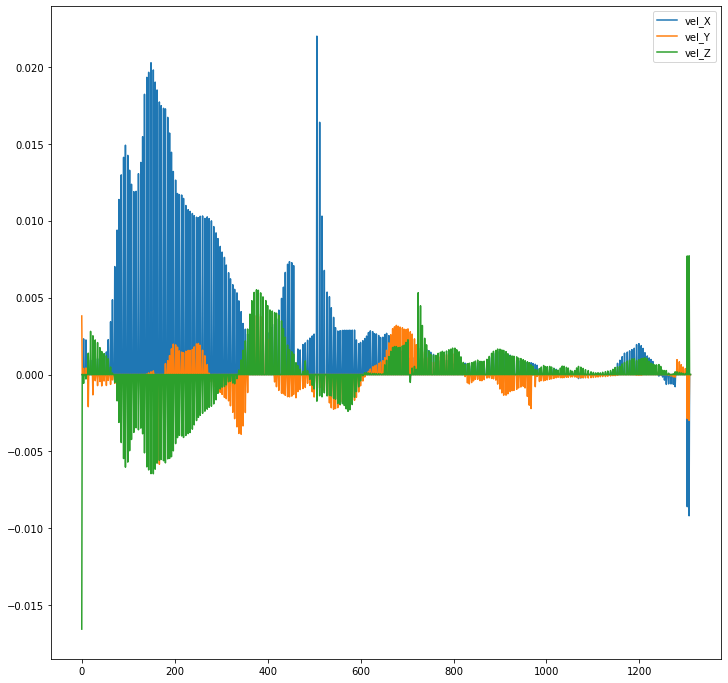

In [51]:
n=0
plot_3d = 1
vel_adjust = -0

W_start = [97.56063,13.35121,-35.21387]
W_end = [97.90633,13.32971,-35.19188]
P_start = [98.09391,13.35522,-35.24588]
P_end = [97.27963,13.61891,-34.86887]
G_start = [97.15163,13.64371,-34.97587]
G_end = [98.27063,13.61921,-34.97287]
B_start = [97.26563,13.84821,-35.02288]
B_end = [98.08563,13.82521,-34.86588]

# names =['W','B','G','P']
# axis3 = ['X','Y','Z']
# groups = ['control','Anchoring','Asynchronized','Synchronized']
# for name in names:
#     # local_name[name  + '_' + 'part_clean'] = pd.read_csv(path + name + '_part_clean.csv',index_col=0)
#     for group in groups:
#         local_name[name  + '_' + group + 'part_clean'] = pd.read_csv(path + name + '_' + group + '_part_clean.csv',index_col=0)

name = 'G'
group = 'control'
column_name = local_name['column_' + name]
local_name[name  + '_' + group + 'part_clean'] = pd.read_csv(path + name + '_' + group + '_part_clean.csv',index_col=0)
# Anchoring_clean_groupby = control_clean_df.groupby(['ID'])

test_grouped = local_name[name  + '_' + group + 'part_clean'].groupby(['ID'])
for h,d in test_grouped:
    if n == 0:
        delta_pos = d[[column_name + 'X',column_name + 'Y',column_name + 'Z']].iloc[0].values - local_name[name  + '_' + 'start']
        # delta_pos = np.array([0,0,0])
    if plot_3d == -1:
        print(n)
        # plt.plot(d[column_name + 'X'].values - d[column_name + 'X'].values.mean() - delta_pos.ravel()[0],label=column_name + 'X')
        # plt.plot(d[column_name + 'Y'].values - d[column_name + 'Y'].values.mean() - delta_pos.ravel()[1],label=column_name + 'Y')
        # plt.plot(d[column_name + 'Z'].values - d[column_name + 'Z'].values.mean() - delta_pos.ravel()[2],label=column_name + 'Z')
        plt.plot(d['vel_X'].values + vel_adjust,label='vel_X')
        plt.plot(d['vel_Y'].values + vel_adjust,label='vel_Y')
        plt.plot(d['vel_Z'].values + vel_adjust,label='vel_Z')
        plt.legend()
        plt.show()
    else:
        if n == plot_3d:
            print(n)
            plt.figure(figsize=(12,12))
            # plt.plot(d[column_name + 'X'].values - d[column_name + 'X'].values.mean() - delta_pos.ravel()[0],label=column_name + 'X')
            # plt.plot(d[column_name + 'Y'].values - d[column_name + 'Y'].values.mean() - delta_pos.ravel()[1],label=column_name + 'Y')
            # plt.plot(d[column_name + 'Z'].values - d[column_name + 'Z'].values.mean() - delta_pos.ravel()[2],label=column_name + 'Z')
            # plt.plot(d['vel_X'][d['vel_X']!=0].values,label='vel_X')
            # plt.plot(d['vel_Y'][d['vel_Y']!=0].values,label='vel_Y')
            # plt.plot(d['vel_Z'][d['vel_Z']!=0].values,label='vel_Z')
            plt.plot(d['vel_X'].values,label='vel_X')
            plt.plot(d['vel_Y'].values,label='vel_Y')
            plt.plot(d['vel_Z'].values,label='vel_Z')
            plt.legend()
            plt.show()
            d['group'] = 'process'
            d[column_name + 'X'] = d[column_name + 'X'] - delta_pos.ravel()[0]
            d[column_name + 'Y'] = d[column_name + 'Y'] - delta_pos.ravel()[1]
            d[column_name + 'Z'] = d[column_name + 'Z'] - delta_pos.ravel()[2]
            d = d.append(pd.DataFrame({column_name + 'X':[local_name[name  + '_' + 'start'][0]],column_name + 'Y':[local_name[name  + '_' + 'start'][1]],column_name + 'Z':[local_name[name  + '_' + 'start'][2]],'group':'start_point'}),ignore_index=True)
            d = d.append(pd.DataFrame({column_name + 'X':[local_name[name  + '_' + 'end'][0]],column_name + 'Y':[local_name[name  + '_' + 'end'][1]],column_name + 'Z':[local_name[name  + '_' + 'end'][2]],'group':'end_point'}),ignore_index=True)
            fig = px.scatter_3d(d, x=column_name + 'X', y=column_name + 'Y', z=column_name + 'Z',color='group')
                # color='left_cogload',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8,) #symbol='CollisionTargetName',symbol_sequence=["cross","circle"]
            fig.update_traces(marker_size = 3)
            fig.show()
            break
    n=n+1

In [53]:
local_name = locals()
column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'
W_start = [97.56063,13.35121,-35.21387]
W_end = [97.90633,13.32971,-35.19188]
P_start = [98.09391,13.35522,-35.24588]
P_end = [97.27963,13.61891,-34.86887]
G_start = [97.15163,13.64371,-34.97587]
G_end = [98.27063,13.61921,-34.97287]
B_start = [97.26563,13.84821,-35.02288]
B_end = [98.08563,13.82521,-34.86588]
participant_id = 2
length_period = 900

### test start and end
group = 'control' # 'control', 'Anchoring', 'Synchronized', 'Asynchronized'
name = 'G'
test_df = pd.read_csv('D:/code/python/nasa/data/result/start_end/' + name + '_' + group + '_df_start.csv')
# test_df = pd.read_csv('D:/code/python/nasa/data/result/start_end/' + name + '_df_start.csv')

column_name = local_name['column_' + name]
test_df = test_df[participant_id*length_period*2:(participant_id+1)*length_period*2]
# test_df = test_df.append(pd.DataFrame({'RobotX':[local_name[name  + '_' + 'start'][0]],'RobotY':[local_name[name  + '_' + 'start'][1]],'RobotZ':[local_name[name  + '_' + 'start'][2]],'data_state':'start_point'}),ignore_index=True)

fig = px.scatter_3d(test_df, x='RobotX', y='RobotY', z='RobotZ',color='data_state')
                # color='left_cogload',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8,) #symbol='CollisionTargetName',symbol_sequence=["cross","circle"]
fig.update_traces(marker_size = 1.5)
fig.show()

In [10]:
## delete group from grouped ##
Anchoring_group_clean = Anchoring_group.drop(Anchoring_pd_groupby.get_group('11Anchoring0').index)
Anchoring_pd_groupby_clean = Anchoring_group_clean.groupby(['ID'])

for header in outlier_header:
    if header != None:
        Anchoring_group = Anchoring_group.drop(Anchoring_pd_groupby.get_group(header).index)
Anchoring_pd_groupby = Anchoring_group.groupby(['ID'])

In [2]:
path = 'D:/code/python/nasa/data/result/0420_start_end/start_entropy/entropy/'
name = 'B'
data = pd.read_csv(path + name + '_combine.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)

# for index,row in data.iteritems():
#     if index != 'Groups':
#         row[row>0.1] = np.nan

# data_mean = data.mean()
# data_std = data.std()
# for index,row in data.iteritems():
#     if index != 'Groups':
#         row[np.abs(row-data_mean[index])>3*data_std[index]] = np.nan
# data = data.interpolate(method='linear',axis=0,limit_direction ='both')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=5.147e-02 stat=3.793e+00
control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=2.366e-03 stat=9.241e+00
control v.s. Synchronized: Kruskal-Wallis paired samples, P_val=2.830e-03 stat=8.914e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=8.168e-02 stat=3.031e+00
Asynchronized v.s. Synchronized: Kruskal-Wallis paired samples, P_val=8.945e-01 stat=1.759e-02
Anchoring v.s. Synchronized: Kruskal-Wallis paired samples, P_val=9.753e-02 stat=2.745e+00


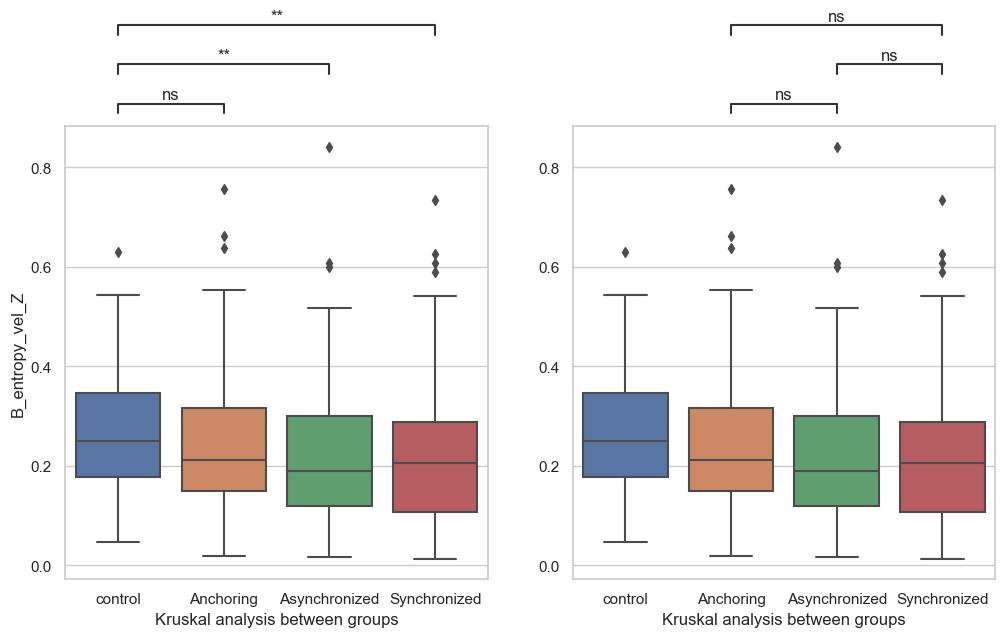

In [3]:
### pair analysis visualization 

sns.set(style = 'whitegrid')
x = 'Groups'
y = 'entropy_vel_Z'
# y = 'mean_vel_Z'
hue = 'Groups'
order = ["control", "Anchoring","Asynchronized","Synchronized"]
method = 'Kruskal'

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1]),(order[0], order[2]),(order[0], order[3])],
                                    test=method, 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
   # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
   # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=name + '_' + y)

if 1:
   # axes[1] = sns.barplot(ax = axes[1],data=data, x=x, y=y,order=order,
   axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,
                  # palette = 'mako',
                  # linewidth=1.5,
                  # errcolor="0.2",errwidth =1.5,
                  # edgecolor=".2",
                  # facecolor=(1, 1, 1, 0)
                  )
   test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                    box_pairs=[(order[1], order[2]),(order[1], order[3]),(order[2], order[3])],
                                    # test='Mann-Whitney', 
                                    test=method, 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -0.5,
                                 #    line_offset= -0.5,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   # axes[1].set(xlabel='Paired analysis between conditions (Greater)', ylabel='')
   axes[1].set(xlabel = method + ' analysis between groups', ylabel='')

In [36]:
path = 'D:/code/python/nasa/data/result/0420_start_end/end_entropy/entropy/'
name = 'Total'
data = pd.read_csv(path + name + '_combine.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)

data['mean_vel_X'] = data['mean_vel_X'][np.abs(data['mean_vel_X'])<0.01]
data['mean_vel_Y'] = data['mean_vel_Y'][np.abs(data['mean_vel_Y'])<0.01]
data['mean_vel_Z'] = data['mean_vel_Z'][np.abs(data['mean_vel_Z'])<0.01]


In [ ]:
### pair analysis visualization start end
for axis in ['X','Y','Z']:
   sns.set(style = 'whitegrid')
   x = 'Groups'
   # y = 'mean_vel_' + axis
   y = 'entropy_vel_' + axis

   hue = 'point_state'
   order = ["control", "Anchoring","Asynchronized","Synchronized"]
   point_states = ["before","after"]
   method = 'Kruskal'

   fig, axes = plt.subplots(1,1, figsize=(6,6), dpi=100)

   if 1:
      axes = sns.boxplot(ax = axes, data=data, x=x, y=y, hue=hue)
      test_results = add_stat_annotation(ax=axes, data=data, x=x, y=y, hue=hue,
                                       box_pairs=[
                                          ((order[0], point_states[0]), (order[0], point_states[1])),
                                          ((order[1], point_states[0]), (order[1], point_states[1])),
                                          ((order[2], point_states[0]), (order[2], point_states[1])),
                                          ((order[3], point_states[0]), (order[3], point_states[1])),
                                          # ((order[0], point_states[0]), (order[1], point_states[0])),
                                          # ((order[0], point_states[0]), (order[2], point_states[0])),
                                          # ((order[0], point_states[0]), (order[3], point_states[0])),
                                          ],
                                       test=method, 
                                       # test='Wilcoxon', 
                                       comparisons_correction=None, 
                                       text_format='star', loc='outside', verbose=1,
                                    #    line_offset_to_box= -1,
                                    #    line_offset= 1,
                                    #    text_offset = -1,
                                       # stats_params={'alternative': 'greater'}
                                       )
      # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
      # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
      # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
      axes.set(xlabel = method + ' analysis between groups', ylabel=name + '_' + y)

      plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)




p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control_after v.s. Anchoring_after: Kruskal-Wallis paired samples, P_val=8.039e-01 stat=6.168e-02
control_after v.s. Asynchronized_after: Kruskal-Wallis paired samples, P_val=2.413e-01 stat=1.373e+00
control_after v.s. Synchronized_after: Kruskal-Wallis paired samples, P_val=2.829e-01 stat=1.153e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Asynchronized_after v.s. Synchronized_after: Kruskal-Wallis paired samples, P_val=7.899e-01 stat=7.099e-02
Anchoring_after v.s. Asynchronized_after: Kruskal-Wallis paired samples, P_val=3.740e-02 stat=4.332e+00
Anchoring_after v.s. Synchronized_after: Kruskal-Wallis paired samples, P_val=5.562e-02 stat=3.663e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*

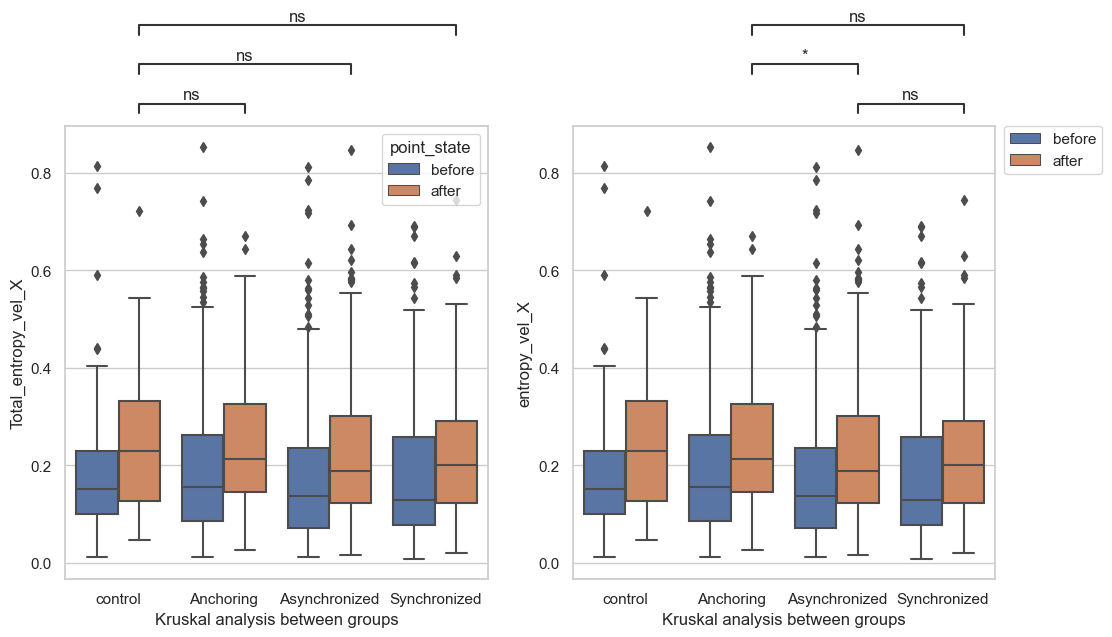

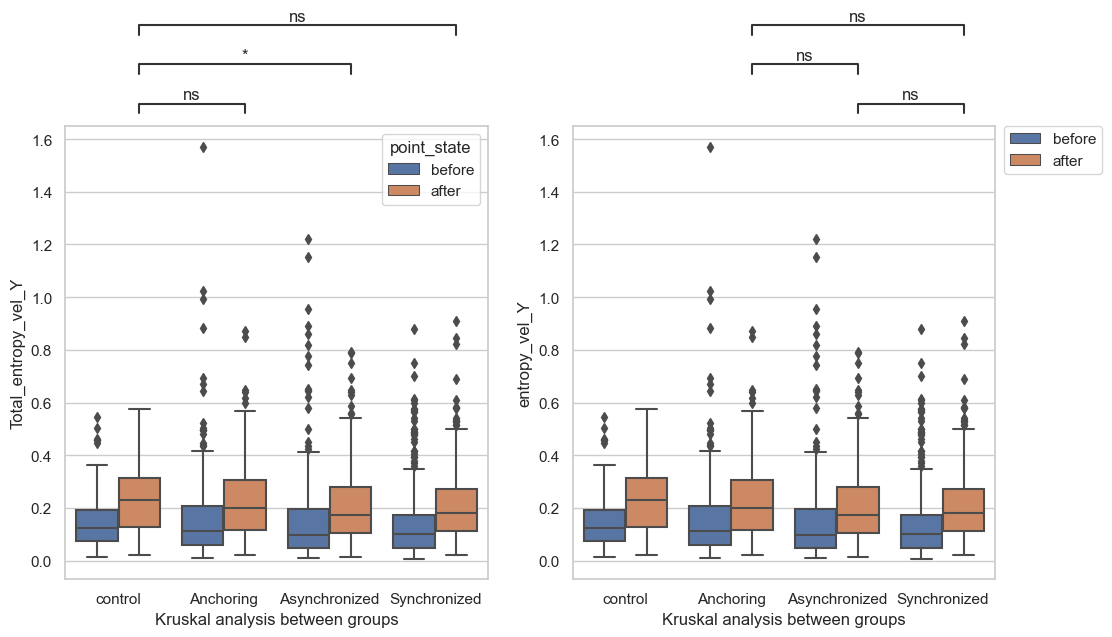

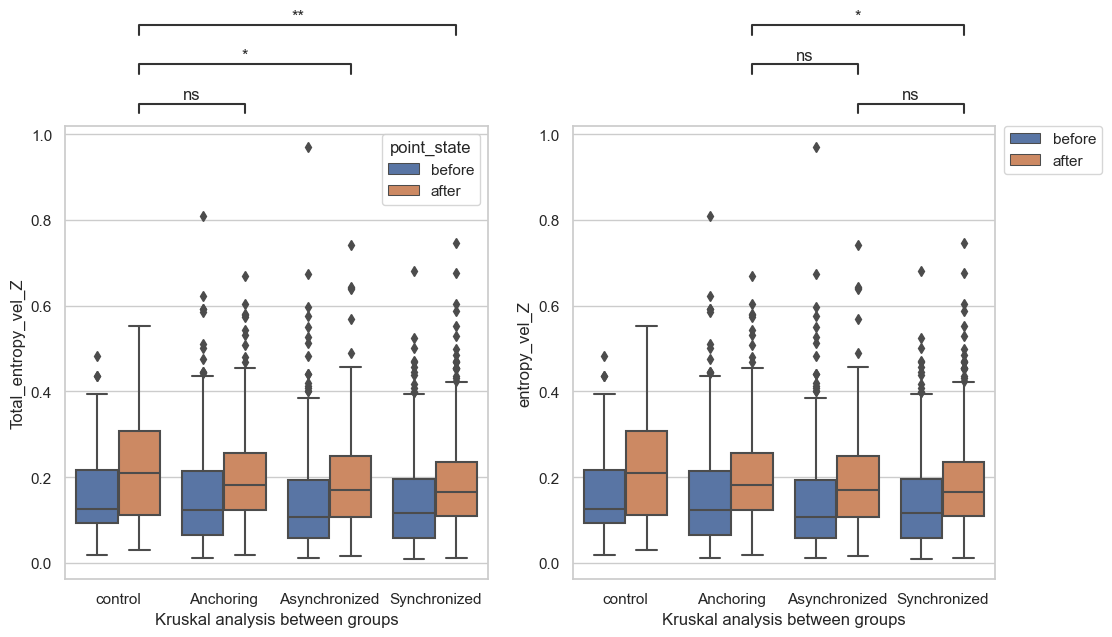

In [40]:
### pair analysis visualization start end
for axis in ['X','Y','Z']:
   sns.set(style = 'whitegrid')
   x = 'Groups'
   # y = 'mean_vel_' + axis
   y = 'entropy_vel_' + axis
   state = 1

   hue = 'point_state'
   order = ["control", "Anchoring","Asynchronized","Synchronized"]
   point_states = ["before","after"]
   method = 'Kruskal'

 

   fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

   if 1:
      axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, hue=hue)
      test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, hue=hue,
                                       box_pairs=[
                                          ((order[0], point_states[state]), (order[1], point_states[state])),
                                          ((order[0], point_states[state]), (order[2], point_states[state])),
                                          ((order[0], point_states[state]), (order[3], point_states[state])),
                                          ],
                                       test=method, 
                                       # test='Wilcoxon', 
                                       comparisons_correction=None, 
                                       text_format='star', loc='outside', verbose=1,
                                    #    line_offset_to_box= -1,
                                    #    line_offset= 1,
                                    #    text_offset = -1,
                                       # stats_params={'alternative': 'greater'}
                                       )
      # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
      # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
      # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
      axes[0].set(xlabel = method + ' analysis between groups', ylabel=name + '_' + y)
      axes[0].legend_.remove()
   if 1:
      axes[1] = sns.boxplot(ax = axes[1], data=data, x=x, y=y, hue=hue)
      test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y, hue=hue,
                                       box_pairs=[
                                          ((order[1], point_states[state]), (order[2], point_states[state])),
                                          ((order[1], point_states[state]), (order[3], point_states[state])),
                                          ((order[2], point_states[state]), (order[3], point_states[state])),
                                          ],
                                       test=method, 
                                       # test='Wilcoxon', 
                                       comparisons_correction=None, 
                                       text_format='star', loc='outside', verbose=1,
                                    #    line_offset_to_box= -1,
                                    #    line_offset= 1,
                                    #    text_offset = -1,
                                       # stats_params={'alternative': 'greater'}
                                       )
      # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
      # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
      # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
      axes[1].set(xlabel = method + ' analysis between groups')
      plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


In [ ]:
path = 'D:/code/python/nasa/data/result/0420_start_end/end_entropy/'
names =['W','B','G','P']
# names =['P']
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
point_states = ['before','after']
total_df = pd.DataFrame()

for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for point_state in point_states:
            local_name[name  + '_' + group + '_' + point_state + '_df'] = pd.DataFrame()
            for axis in axis3:
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean.npy')
                # if name == 'P':
                #     if len(local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'])>88:
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'][:-1]
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'][:-1]
                # local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['entropy' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['mean' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
                

                
                # local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
            local_name[name  + '_' + group + '_' + point_state + '_df']['point_state'] = point_state
            local_name[name  + '_' + group + '_df'] = local_name[name  + '_' + group + '_df'].append(local_name[name  + '_' + group + '_' + point_state + '_df'])
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_combine.csv")    

In [ ]:
path = 'D:/code/python/nasa/data/result/0420_start_end/end_entropy/'
names =['W','B','G','P']
# names =['P']
axis3 = ['X','Y','Z']
groups = ['control','Anchoring','Asynchronized','Synchronized']
point_states = ['before','after']
total_df = pd.DataFrame()

for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for point_state in point_states:
            local_name[name  + '_' + group + '_' + point_state + '_df'] = pd.DataFrame()
            for axis in axis3:
                # local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy.npy')
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean.npy')
                # if name == 'P':
                #     if len(local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'])>88:
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'][:-1]
                local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'][:-1]
                # local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['entropy' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name  + '_' + group + '_' + point_state + '_df']['mean' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
                

                
                # local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_' + point_state + '_vel_' + axis + '_mean']
            local_name[name  + '_' + group + '_' + point_state + '_df']['point_state'] = point_state
            local_name[name  + '_' + group + '_df'] = local_name[name  + '_' + group + '_df'].append(local_name[name  + '_' + group + '_' + point_state + '_df'])
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_combine.csv")    

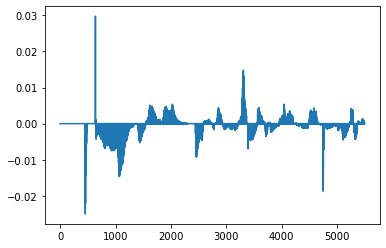

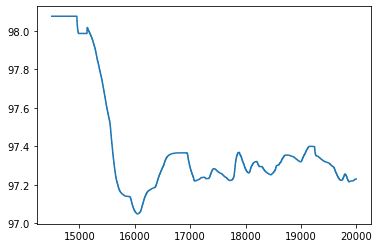

In [81]:
vel_cube1_x = []
v_previous = 0
name = 'Cube1X'
for i,v in t[name].iteritems():
    if abs(v-v_previous)>0.5:
        vel_cube1_x.append(0)
    # elif abs(v-v_previous)>0:
    else:
        vel_cube1_x.append(v-v_previous)
    v_previous = v
vel_df = pd.DataFrame({"vel_x":vel_cube1_x[14500:20000]})

# vel_df['vel_x'][vel_df['vel_x'] == 0] = np.nan
# vel_df = vel_df.interpolate(method='linear',axis=0,limit_direction ='both')
# vel_df.dropna(axis=0)
plt.plot(vel_df)
plt.show()
plt.plot(t[name][14500:20000])


In [189]:
def ApEn(U, m, r) -> float:
    """Approximate_entropy."""

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return _phi(m) - _phi(m + 1)

In [3]:
def SampEn_csdn(U, m, r):

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        B = [(len([1 for x_j in x if _maxdist(x_i, x_j) <= r])-1.0)/(N-m) for x_i in x]
        return (N-m+1.0)**(-1)*sum(B)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))

In [190]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))

In [14]:
def Approximate_Entropy(x, m, r=0.15):
    """
    近似熵
    m 滑动时窗的长度
    r 阈值系数 取值范围一般为：0.1~0.25
    """
    # 将x转化为数组
    x = np.array(x)
    # 检查x是否为一维数据
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    # 计算x的行数是否小于m+1
    if len(x) < m+1:
        raise ValueError("len(x)小于m+1")
    # 将x以m为窗口进行划分
    entropy = 0  # 近似熵
    for temp in range(2):
        X = []
        for i in range(len(x)-m+1-temp):
            X.append(x[i:i+m+temp])
        X = np.array(X)
        # 计算X任意一行数据与所有行数据对应索引数据的差值绝对值的最大值
        D_value = []  # 存储差值
        for i in X:
            sub = []
            for j in X:
                sub.append(max(np.abs(i-j)))
            D_value.append(sub)
        # 计算阈值
        F = r*np.std(x, ddof=1)
        # 判断D_value中的每一行中的值比阈值大的个数除以len(x)-m+1的比例
        num = np.sum(D_value>F, axis=1)/(len(x)-m+1-temp)
        # 计算num的对数平均值
        Lm = np.average(np.log(num))
        entropy = abs(entropy) - Lm

    return entropy

In [15]:
def Sample_Entropy(x, m, r=0.15):
    """
    样本熵
    m 滑动时窗的长度
    r 阈值系数 取值范围一般为：0.1~0.25
    """
    # 将x转化为数组
    x = np.array(x)
    # 检查x是否为一维数据
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    # 计算x的行数是否小于m+1
    if len(x) < m+1:
        raise ValueError("len(x)小于m+1")
    # 将x以m为窗口进行划分
    entropy = 0  # 近似熵
    for temp in range(2):
        X = []
        for i in range(len(x)-m+1-temp):
            X.append(x[i:i+m+temp])
        X = np.array(X)
        # 计算X任意一行数据与所有行数据对应索引数据的差值绝对值的最大值
        D_value = []  # 存储差值
        for index1, i in enumerate(X):
            sub = []
            for index2, j in enumerate(X):
                if index1 != index2:
                    sub.append(max(np.abs(i-j)))
            D_value.append(sub)
        # 计算阈值
        F = r*np.std(x, ddof=1)
        # 判断D_value中的每一行中的值比阈值大的个数除以len(x)-m+1的比例
        num = np.sum(D_value>F, axis=1)/(len(X)-m+1-temp)
        # 计算num的对数平均值
        Lm = np.average(np.log(num))
        entropy = abs(entropy) - Lm

    return entropy

In [16]:
def Fuzzy_Entropy(x, m, r=0.25, n=2):
    """
    模糊熵
    m 滑动时窗的长度
    r 阈值系数 取值范围一般为：0.1~0.25
    n 计算模糊隶属度时的维度
    """
    # 将x转化为数组
    x = np.array(x)
    # 检查x是否为一维数据
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    # 计算x的行数是否小于m+1
    if len(x) < m+1:
        raise ValueError("len(x)小于m+1")
    # 将x以m为窗口进行划分
    entropy = 0  # 近似熵
    for temp in range(2):
        X = []
        for i in range(len(x)-m+1-temp):
            X.append(x[i:i+m+temp])
        X = np.array(X)
        # 计算X任意一行数据与其他行数据对应索引数据的差值绝对值的最大值
        D_value = []  # 存储差值
        for index1, i in enumerate(X):
            sub = []
            for index2, j in enumerate(X):
                if index1 != index2:
                    sub.append(max(np.abs(i-j)))
            D_value.append(sub)
        # 计算模糊隶属度
        D = np.exp(-np.power(D_value, n)/r)
        # 计算所有隶属度的平均值
        Lm = np.average(D.ravel())
        entropy = abs(entropy) - Lm

    return entropy

In [224]:
noise = 0.6

x = np.arange(0,20*np.pi,0.1)   
# y = np.sin(x)
y = x
y_small_noise = []
y_large_noise = []
y_sin_noise = []
for i in range(len(y)):
    small_noise = np.random.normal(0,noise,1)
    large_noise = np.random.normal(0,noise*2,1)
    y_small_noise.append(y[i] + small_noise)
    y_large_noise.append(y[i] + large_noise)
    # y_sin_noise.append(y[i] + y_sin[i])

y = np.array(y)
y_small_noise = np.array(y_small_noise).ravel()
y_large_noise = np.array(y_large_noise).ravel()
# y_sin_noise = np.array(y_sin_noise).ravel()


In [225]:
m = 2
set_r = 0.1
# ae_origin = ApEn(y, m, r=set_r)
# ae_small_noise = ApEn(y_small_noise, m, r=set_r)
# ae_large_noise = ApEn(y_large_noise, m, r=set_r) 
se_origin = SampEn(y, m, r=set_r)
se_small_noise = SampEn(y_small_noise, m, r=set_r)
se_large_noise = SampEn(y_large_noise, m, r=set_r) 
# se_csdn_origin = SampEn_csdn(y, m, r=set_r * np.std(y))
# se_csdn_small_noise = SampEn_csdn(y_small_noise, m, r=set_r * np.std(y_small_noise))
# se_csdn_large_noise = SampEn_csdn(y_large_noise, m, r=set_r * np.std(y_large_noise)) 
# ae_origin = Approximate_Entropy(y, m, r=set_r)
# ae_small_noise = Approximate_Entropy(y_small_noise, m, r=set_r)
# ae_large_noise = Approximate_Entropy(y_large_noise, m, r=set_r) 
# se_origin = Sample_Entropy(y, m, r=set_r)
# se_small_noise = Sample_Entropy(y_small_noise, m, r=set_r)
# se_large_noise = Sample_Entropy(y_large_noise, m, r=set_r) 
# fe_origin = Fuzzy_Entropy(y, m, r=set_r)
# fe_small_noise = Fuzzy_Entropy(y_small_noise, m, r=set_r)
# fe_large_noise = Fuzzy_Entropy(y_large_noise, m, r=set_r) 

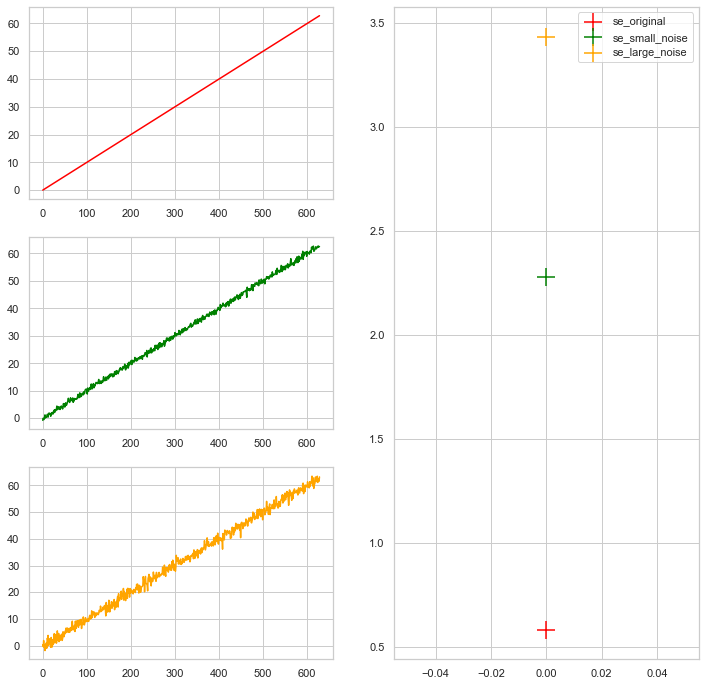

In [226]:
plt.figure(figsize=(12,12))
plt.subplot(321)
plt.plot(y,c="red")
plt.subplot(323)
plt.plot(y_small_noise,c="green")
plt.subplot(325)
plt.plot(y_large_noise,c="orange")
plt.subplot(122)
# plt.scatter([0,0,0],[en_origin,en_small_noise,en_large_noise],c=["red","green","orange"],marker='+')
# plt.scatter([0,0,0,0],[en_origin,ae_origin,se_origin,fe_origin],c=["red","green","orange","blue"])
# plt.scatter([0,0,0,0],[en_small_noise,ae_small_noise,se_small_noise,fe_small_noise],c=["red","green","orange","blue"])
# plt.scatter([0,0,0,0],[en_large_noise,ae_large_noise,se_large_noise,fe_large_noise],c=["red","green","orange","blue"])
# plt.scatter([0],[ae_origin],c=["red"],marker='.',label='ae_original',s=300)
plt.scatter([0],[se_origin],c=["red"],marker='+',label='se_original',s=300)
# plt.scatter([0],[ae_small_noise],c=["green"],marker='.',label='ae_small_noise',s=300)
plt.scatter([0],[se_small_noise],c=["green"],marker='+',label='se_small_noise',s=300)
# plt.scatter([0],[ae_large_noise],c=["orange"],marker='.',label='ae_large_noise',s=300)
plt.scatter([0],[se_large_noise],c=["orange"],marker='+',label='se_large_noise',s=300)
plt.legend()
plt.show()


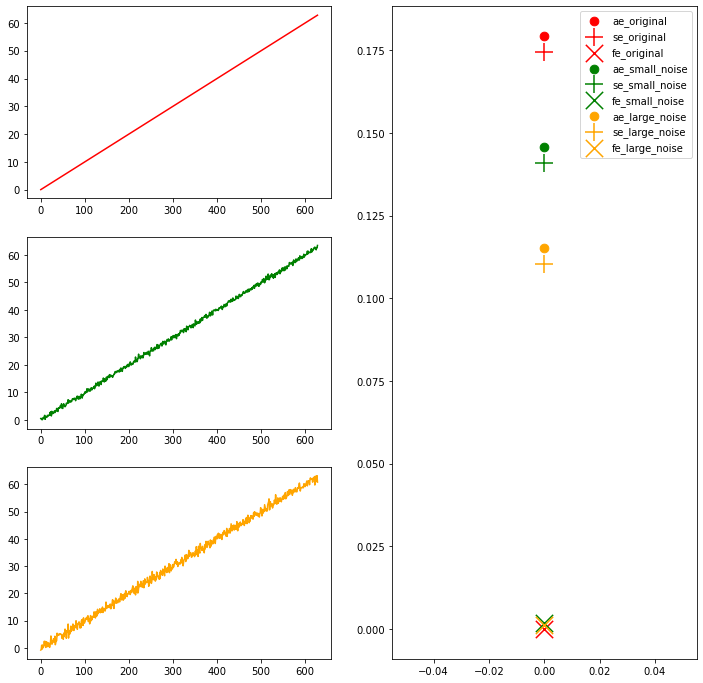

In [91]:
plt.figure(figsize=(12,12))
plt.subplot(321)
plt.plot(y,c="red")
plt.subplot(323)
plt.plot(y_small_noise,c="green")
plt.subplot(325)
plt.plot(y_large_noise,c="orange")
plt.subplot(122)
# plt.scatter([0,0,0],[en_origin,en_small_noise,en_large_noise],c=["red","green","orange"])
# plt.scatter([0,0,0,0],[en_origin,ae_origin,se_origin,fe_origin],c=["red","green","orange","blue"])
# plt.scatter([0,0,0,0],[en_small_noise,ae_small_noise,se_small_noise,fe_small_noise],c=["red","green","orange","blue"])
# plt.scatter([0,0,0,0],[en_large_noise,ae_large_noise,se_large_noise,fe_large_noise],c=["red","green","orange","blue"])
plt.scatter([0],[ae_origin],c=["red"],marker='.',label='ae_original',s=300)
plt.scatter([0],[se_origin],c=["red"],marker='+',label='se_original',s=300)
plt.scatter([0],[fe_origin],c=["red"],marker='x',label='fe_original',s=300)
plt.scatter([0],[ae_small_noise],c=["green"],marker='.',label='ae_small_noise',s=300)
plt.scatter([0],[se_small_noise],c=["green"],marker='+',label='se_small_noise',s=300)
plt.scatter([0],[fe_small_noise],c=["green"],marker='x',label='fe_small_noise',s=300)
plt.scatter([0],[ae_large_noise],c=["orange"],marker='.',label='ae_large_noise',s=300)
plt.scatter([0],[se_large_noise],c=["orange"],marker='+',label='se_large_noise',s=300)
plt.scatter([0],[fe_large_noise],c=["orange"],marker='x',label='fe_large_noise',s=300)
plt.legend()
plt.show()
